Images taken during the last FISH experiment (2020), on the SP8 Leica microscope.

## Import the python libraries

In [1]:
# To import the files
import glob
from pathlib import Path

# To read the dataframes
import pandas as pd
import numpy as np

# To plot the images
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid, AxesGrid
import seaborn as sns

# To analyse the images
from skimage.filters import gaussian, median
from skimage.restoration import estimate_sigma

# To export image in the different formats: png, ...
import imageio

# To draw manual ROI on the images
from roipoly import MultiRoi

## Eukaryote dataframe

### Load the eukaryote dataframe

In [2]:
# Read the image dataframe parquet file:
df_eukaryote = pd.read_parquet('parquets/df_eukaryote.parquet')

In [3]:
df_eukaryote.head(10)

,file,serie,channel,nbr_frames,shape_X,shape_Y,channel_count,Image.@UniqueID,Channel.@LUTName,Dimension.@DimID_X,...,Dimension.@NumberOfElements_Y,Dimension.@Length_Y,Dimension.@Unit_Y,ATLConfocalSettingDefinition.@ScanSpeed,ATLConfocalSettingDefinition.@Zoom,ATLConfocalSettingDefinition.@PixelDwellTime,ATLConfocalSettingDefinition.DetectorList.Detector.@Name,ATLConfocalSettingDefinition.DetectorList.Detector.@Type,ATLConfocalSettingDefinition.DetectorList.Detector.@Gain,ATLConfocalSettingDefinition.DetectorList.Detector.@Offset
168,200316_1_NoProbes.lif,Image001,0,1,512,512,4,07e1048b-6795-11ea-a94d-002432168676,Blue,1,...,512,0.000185,m,400.0,1.000000,0.000003,PMT 3,PMT,600.289921,0.000000
169,200316_1_NoProbes.lif,Image001,1,1,512,512,4,07e1048b-6795-11ea-a94d-002432168676,Green,1,...,512,0.000185,m,400.0,1.000000,0.000003,HyD4 SMD,HyD,350.666885,-0.006667
170,200316_1_NoProbes.lif,Image001,2,1,512,512,4,07e1048b-6795-11ea-a94d-002432168676,Gray,1,...,512,0.000185,m,400.0,1.000000,0.000003,PMT Trans,PMT,350.537881,0.000000
171,200316_1_NoProbes.lif,Image001,3,1,512,512,4,07e1048b-6795-11ea-a94d-002432168676,Red,1,...,512,0.000185,m,400.0,1.000000,0.000003,PMT 5,PMT,600.404364,0.000000
172,200316_1_NoProbes.lif,Image002,0,1,512,512,4,30830004-6795-11ea-a94d-002432168676,Blue,1,...,512,0.000185,m,400.0,1.000000,0.000003,PMT 3,PMT,600.289921,0.000000
173,200316_1_NoProbes.lif,Image002,1,1,512,512,4,30830004-6795-11ea-a94d-002432168676,Green,1,...,512,0.000185,m,400.0,1.000000,0.000003,HyD4 SMD,HyD,350.666885,-0.006667
174,200316_1_NoProbes.lif,Image002,2,1,512,512,4,30830004-6795-11ea-a94d-002432168676,Gray,1,...,512,0.000185,m,400.0,1.000000,0.000003,PMT Trans,PMT,350.537881,0.000000
175,200316_1_NoProbes.lif,Image002,3,1,512,512,4,30830004-6795-11ea-a94d-002432168676,Red,1,...,512,0.000185,m,400.0,1.000000,0.000003,PMT 5,PMT,600.404364,0.000000
256,200316_3_Triton_Probes.lif,Image001,0,1,632,632,4,fbbd1930-6793-11ea-a94d-002432168676,Blue,1,...,632,0.000037,m,400.0,5.000013,0.000003,PMT 3,PMT,600.289921,0.000000
257,200316_3_Triton_Probes.lif,Image001,1,1,632,632,4,fbbd1930-6793-11ea-a94d-002432168676,Green,1,...,632,0.000037,m,400.0,5.000013,0.000003,HyD4 SMD,HyD,350.666885,-0.006667


In [4]:
df_eukaryote.loc[253]

file                                                                           200316_Sample_6.lif
serie                                                                                     Image012
channel                                                                                          1
nbr_frames                                                                                       1
shape_X                                                                                       3144
shape_Y                                                                                       3144
channel_count                                                                                    4
Image.@UniqueID                                               7262937e-6790-11ea-a94d-002432168676
Channel.@LUTName                                                                             Green
Dimension.@DimID_X                                                                               1
Dimension.

In [5]:
df_eukaryote.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 168 to 455
Data columns (total 24 columns):
 #   Column                                                      Non-Null Count  Dtype   
---  ------                                                      --------------  -----   
 0   file                                                        484 non-null    object  
 1   serie                                                       484 non-null    object  
 2   channel                                                     484 non-null    int64   
 3   nbr_frames                                                  484 non-null    int64   
 4   shape_X                                                     484 non-null    int64   
 5   shape_Y                                                     484 non-null    int64   
 6   channel_count                                               484 non-null    int64   
 7   Image.@UniqueID                                             484 non-null    ob

#### Check the values of interest for the analysis

In [6]:
np.unique(df_eukaryote[['Dimension.@NumberOfElements_X', 'Dimension.@NumberOfElements_Y']].values, return_counts=True)

(array([320, 512, 632, 3144], dtype=object), array([  8, 280, 392, 288]))

In [7]:
df_eukaryote['ATLConfocalSettingDefinition.@ScanSpeed'].unique()

array([400.])

Same scan speed used for all the images: 400 Hz

In [8]:
df_eukaryote['ATLConfocalSettingDefinition.@Zoom'].value_counts()

5.000013     268
1.000000     212
10.000025      4
Name: ATLConfocalSettingDefinition.@Zoom, dtype: int64

Three different zoom setting are used: 1, 5 and 10 time.

In [9]:
df_eukaryote['ATLConfocalSettingDefinition.@PixelDwellTime'].value_counts()

2.562500e-06    196
5.125000e-07    144
3.162500e-06    140
5.075000e-06      4
Name: ATLConfocalSettingDefinition.@PixelDwellTime, dtype: int64

In [10]:
df_eukaryote.groupby('Channel.@LUTName')['ATLConfocalSettingDefinition.DetectorList.Detector.@Gain'].value_counts()

Channel.@LUTName  ATLConfocalSettingDefinition.DetectorList.Detector.@Gain
Blue              600.289921                                                  114
                  600.308995                                                    7
Gray              350.537881                                                  114
                  400.034333                                                    7
Green             350.666885                                                  114
                  349.980225                                                    7
Red               600.881209                                                   58
                  600.404364                                                   56
                  600.862135                                                    7
Name: ATLConfocalSettingDefinition.DetectorList.Detector.@Gain, dtype: int64

In [11]:
df_eukaryote.groupby('Channel.@LUTName')['ATLConfocalSettingDefinition.DetectorList.Detector.@Offset'].value_counts()

Channel.@LUTName  ATLConfocalSettingDefinition.DetectorList.Detector.@Offset
Blue               0.000000                                                     114
                  -0.073333                                                       7
Gray               0.000000                                                     121
Green             -0.006667                                                     121
Red                0.000000                                                     121
Name: ATLConfocalSettingDefinition.DetectorList.Detector.@Offset, dtype: int64

## Load the numpy files containing the images

In [12]:
image_arrays = sorted(glob.glob('../image_processing/image_arrays/*.npy'))

In [13]:
image_arrays

['../image_processing/image_arrays/0_images_320_320.npy',
 '../image_processing/image_arrays/1_images_512_512.npy',
 '../image_processing/image_arrays/2_images_600_600.npy',
 '../image_processing/image_arrays/3_images_632_632.npy',
 '../image_processing/image_arrays/4_images_1408_1408.npy',
 '../image_processing/image_arrays/5_images_1872_1872.npy',
 '../image_processing/image_arrays/6_images_2480_2480.npy',
 '../image_processing/image_arrays/7_images_2608_2608.npy',
 '../image_processing/image_arrays/8_images_3144_3144.npy']

In [14]:
image_info = pd.read_parquet('image_info_dataframe.parquet')

In [15]:
shape_dict = image_info.groupby(['shape_X', 'shape_Y']).indices

In [16]:
name_list = []
shape_list = []
arrays = dict()

for indices, array in zip(shape_dict, image_arrays):
    name_list.append(Path(array).stem)
    shape_list.append(indices)
    images = np.load(array)
    for idx, img in zip(shape_dict[indices], images):
        arrays.update({idx:img})

In [17]:
len(arrays)

1188

In [18]:
name_list

['0_images_320_320',
 '1_images_512_512',
 '2_images_600_600',
 '3_images_632_632',
 '4_images_1408_1408',
 '5_images_1872_1872',
 '6_images_2480_2480',
 '7_images_2608_2608',
 '8_images_3144_3144']

In [19]:
shape_list

[(320, 320),
 (512, 512),
 (600, 600),
 (632, 632),
 (1408, 1408),
 (1872, 1872),
 (2480, 2480),
 (2608, 2608),
 (3144, 3144)]

## Test on three different images

### Images selected for testing

In [20]:
# indexes for the different channels
img1 = list(range(88,92))
img2 = list(range(108,112))
img3 = list(range(120,124))

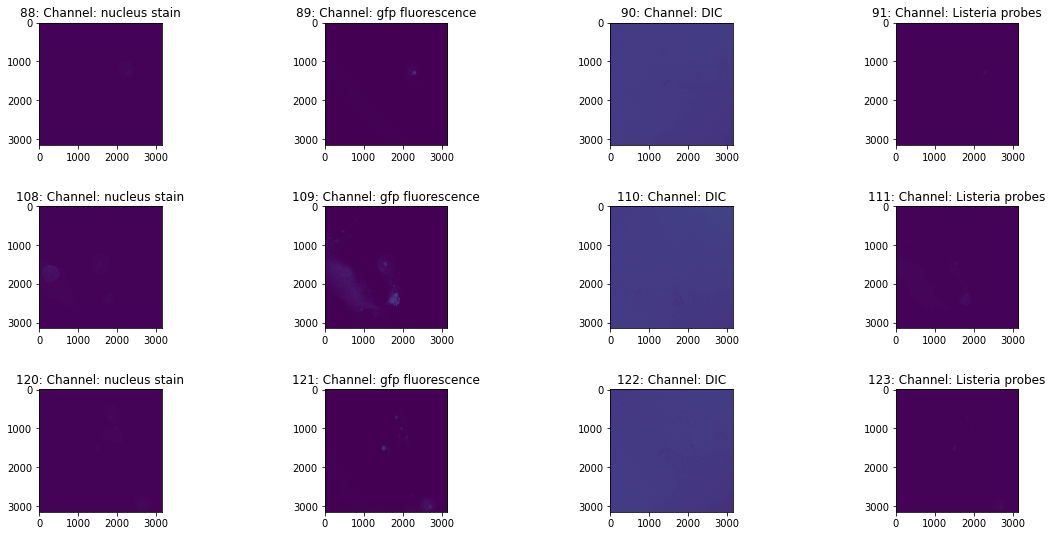

CPU times: user 4.15 s, sys: 263 ms, total: 4.41 s
Wall time: 4.46 s


In [21]:
%%time
%matplotlib inline

row = 3
col = 4

a = col*5
b = row*3

k = 0
t = 0

title = ['nucleus stain', 'gfp fluorescence', 'DIC', 'Listeria probes']

fig = plt.figure(figsize=(a, b))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
for idx in (img1 + img2 + img3):
    plt.subplot(row, col, k+1)
    plt.imshow(arrays[idx], vmin=0, vmax=255)
    plt.title(f'{idx}: Channel: {title[t]}')
    k=k+1
    if t == 3:
        t = 0
    else:
        t = t+1
        
    
plt.show()

### Intensity analysis based on the GFP channels

In [22]:
# GFP and Probe test images
#gfp_idx = [img1[1], img2[1], img3[1]]
#probe_idx = [img1[3], img2[3], img3[3]]

In [23]:
set(df_eukaryote['file'])

{'200310_Probes.lif',
 '200311_Sample_1.lif',
 '200311_Sample_11.lif',
 '200311_Sample_2.lif',
 '200311_Sample_4.lif',
 '200311_Sample_9.lif',
 '200316_1_NoProbes.lif',
 '200316_3_Triton_Probes.lif',
 '200316_Sample_10.lif',
 '200316_Sample_12.lif',
 '200316_Sample_4.lif',
 '200316_Sample_5.lif',
 '200316_Sample_6.lif'}

In [24]:
# Select the filme of interest

read_file = '200316_Sample_12.lif'

In [85]:
# GFP and Probe images

gfp_idx = df_eukaryote.loc[(df_eukaryote['file'] == read_file) & (df_eukaryote['Channel.@LUTName'] == 'Green')].index.tolist()
probe_idx = df_eukaryote.loc[(df_eukaryote['file'] == read_file) & (df_eukaryote['Channel.@LUTName'] == 'Red')].index.tolist()
DIC_idx = df_eukaryote.loc[(df_eukaryote['file'] == read_file) & (df_eukaryote['Channel.@LUTName'] == 'Gray')].index.tolist()
nucleus_idx = df_eukaryote.loc[(df_eukaryote['file'] == read_file) & (df_eukaryote['Channel.@LUTName'] == 'Blue')].index.tolist()

In [26]:
def get_images_from_idx(index_list):
    ''' Return a list of images corresponding to the indexes'''
    
    images = []
    
    for idx in index_list:
        images.append(arrays[idx])
    return images


def create_ROIs_list_name(ROI_number):
    '''To create a list a ROI names that will contain the different created ROIs'''
    
    roi_list = []
    for num in list(range(ROI_number)):
        roi_list.append(f'roi_{num}')
    return roi_list


def get_ROIs_mean_and_std(multi_roi, image):
    '''List the names, means and the standard deviation calculated for each drawn ROIs'''
    
    name_list = []
    mean_list = []
    std_list = []

    for name, roi in multi_roi.rois.items():
        name_list.append(name)
        m, s = roi.get_mean_and_std(image)
        mean_list.append(m)
        std_list.append(s)
        
    return name_list, mean_list, std_list 


def get_ROI_masks(multi_roi, image, image_index):
    '''Retrieve and save the ROIs location as a list of numpy array masks'''
    
    mask_list = []
    
    for name, roi in multi_roi.rois.items():
        mask = roi.get_mask(image)
        mask_list.append(mask)
        
    return mask_list, np.save( f'masks_{image_index}', mask_list)


def get_ROI_area(masks):
    '''Return the area for all the calculated ROIs'''
    
    area_list = []
    
    for msk in masks:
        area_list.append(np.sum(msk.astype(np.int)))
       
    return area_list


def get_min_and_max(mask, current_image):
    '''Return the min and max intensity pixel based on the roi of an image'''
    
    minimum = np.amin(np.extract(mask, current_image))
    maximum = np.amax(np.extract(mask, current_image))
    
    return minimum, maximum



def get_ROI_min_and_max(masks, current_image):
    '''Return the list of min and max intensity pixel for all the ROI of an image'''
    
    min_px = []
    max_px = []

    for msk in masks:
        mn, mx = get_min_and_max(msk, current_image)
        min_px.append(mn)
        max_px.append(mx)
        
    return min_px, max_px

In [27]:
# Retrieve the gfp channel of the three selected channels
gfp_img = get_images_from_idx(gfp_idx)
probe_img = get_images_from_idx(probe_idx)

#### Positive sampling

In [28]:
%matplotlib qt

idx_gfp_list = []
idx_probes_list = []
type_img_list = []

# GFP results
name_gfp = []
mean_gfp = []
std_gfp = []
ROI_drawn_gfp = []
area_gfp = []
min_px_list_gfp = []
max_px_list_gfp = []

# Probe results
mean_probes = []
std_probes = []
min_px_list_probes = []
max_px_list_probes = []


# Show the image
for i in range(len(gfp_idx)):
    
    img_gfp = gfp_img[i]
    idx_gfp = gfp_idx[i]
    
    img_probe = probe_img[i]
    idx_probe = probe_idx[i]
    
    fig = plt.figure()
    plt.imshow(img_gfp, cmap='viridis', vmin=0, vmax=255)
    plt.title(f'{idx_gfp}: Channel: GFP fluorescence')
    
    # Create empty ROI list
    numb_of_roi = 10
    rois = create_ROIs_list_name(numb_of_roi)
    
    # Draw multiple ROIs
    multiroi_img = MultiRoi(fig=fig, ax=None, roi_names=rois, color_cycle=('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'pink'))
    
    # Create a saved numpy array file of the masks
    masks, _ = get_ROI_masks(multiroi_img, img_gfp, idx_gfp)
    
    # Names, means and stds of the ROIs
    name_g, mean_g, std_g = get_ROIs_mean_and_std(multiroi_img, img_gfp)
    name_gfp.append(name_g)
    mean_gfp.append(mean_g)
    std_gfp.append(std_g)
    
    name_p, mean_p, std_p = get_ROIs_mean_and_std(multiroi_img, img_probe)
    mean_probes.append(mean_p)
    std_probes.append(std_p)
    
    # Number ROIs
    num_ROIs = len(multiroi_img.rois)
    ROI_drawn_gfp.append(num_ROIs)
    
    # Create lists for columns 'image_idx' and 'type_image'
    for i in range(num_ROIs):
        idx_gfp_list.append(idx_gfp)
        idx_probes_list.append(idx_probe)
    
    # Area ROIs
    area = get_ROI_area(masks)
    area_gfp.append(area)
    
    # Min and Max pixel for each ROI
    min_px_list_g, max_px_list_g = get_ROI_min_and_max(masks, img_gfp) 
    min_px_list_gfp.append(min_px_list_g)
    max_px_list_gfp.append(max_px_list_g)
    
    min_px_list_p, max_px_list_p = get_ROI_min_and_max(masks, img_probe)
    min_px_list_probes.append(min_px_list_p)
    max_px_list_probes.append(max_px_list_p)

In [29]:
# Create the dataframe column by column with the retrieved information for the gfp channel:

idx_image = pd.to_numeric(pd.Series(data=idx_gfp_list).explode().reset_index(drop=True))
roi_name = pd.Series(data=name_gfp).explode().reset_index(drop=True)
average_px_intensity = pd.to_numeric(pd.Series(data=mean_gfp).explode().reset_index(drop=True))
std_px_intensity = pd.to_numeric(pd.Series(data=std_gfp).explode().reset_index(drop=True))
roi_px_area = pd.to_numeric(pd.Series(data=area_gfp).explode().reset_index(drop=True))
min_px_intensity = pd.to_numeric(pd.Series(data=min_px_list_gfp).explode().reset_index(drop=True))
max_px_intensity = pd.to_numeric(pd.Series(data=max_px_list_gfp).explode().reset_index(drop=True))

df_gfp = pd.DataFrame(data={'idx_image': idx_image, 'roi_name': roi_name, 'average_px_intensity': average_px_intensity, 'std_px_intensity': std_px_intensity, 'roi_px_area': roi_px_area,
                            'min_px_intensity': min_px_intensity, 'max_px_intensity': max_px_intensity})
df_gfp.insert(1, 'type_image', 'Observed_L-form')
df_gfp.insert(2, 'channel', 'GFP')
df_gfp[['type_image', 'channel']] = df_gfp[['type_image', 'channel']].astype('category')

In [30]:
df_gfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   idx_image             79 non-null     float64 
 1   type_image            81 non-null     category
 2   channel               81 non-null     category
 3   roi_name              79 non-null     object  
 4   average_px_intensity  79 non-null     float64 
 5   std_px_intensity      79 non-null     float64 
 6   roi_px_area           79 non-null     float64 
 7   min_px_intensity      79 non-null     float64 
 8   max_px_intensity      79 non-null     float64 
dtypes: category(2), float64(6), object(1)
memory usage: 4.9+ KB


In [31]:
# Time stamp for the dataframes
running_time = pd.Timestamp.now(tz=None)

In [43]:
df_gfp.to_parquet(f'parquets/df_gfp_{read_file}_{running_time}.parquet'.replace(' ', '_'))

In [45]:
pd.read_parquet(f'parquets/df_gfp_{read_file}_{running_time}.parquet'.replace(' ', '_'))

,idx_image,type_image,channel,roi_name,average_px_intensity,std_px_intensity,roi_px_area,min_px_intensity,max_px_intensity
0,21.0,Observed_L-form,GFP,roi_0,22.777982,15.223361,1090.0,0.0,80.0
1,21.0,Observed_L-form,GFP,roi_1,23.660377,14.472629,159.0,0.0,70.0
2,21.0,Observed_L-form,GFP,roi_2,25.168784,15.929641,6375.0,0.0,255.0
3,25.0,Observed_L-form,GFP,roi_0,32.670455,19.041355,176.0,0.0,97.0
4,25.0,Observed_L-form,GFP,roi_1,34.521739,16.908628,23.0,8.0,70.0
...,...,...,...,...,...,...,...,...,...
76,165.0,Observed_L-form,GFP,roi_0,23.284404,17.866011,109.0,0.0,99.0
77,165.0,Observed_L-form,GFP,roi_0,6.599099,23.001892,444.0,0.0,164.0
78,165.0,Observed_L-form,GFP,roi_1,29.310476,43.907834,525.0,0.0,255.0
79,NaN,Observed_L-form,GFP,roi_2,45.324440,49.275643,937.0,0.0,255.0


In [46]:
# Create the dataframe column by column with the retrieved information for the probe channel:

idx_image = pd.Series(data=idx_probes_list).explode().reset_index(drop=True)
roi_name = pd.Series(data=name_gfp).explode().reset_index(drop=True)
average_px_intensity = pd.to_numeric(pd.Series(data=mean_probes).explode().reset_index(drop=True))
std_px_intensity = pd.to_numeric(pd.Series(data=std_probes).explode().reset_index(drop=True))
roi_px_area = pd.to_numeric(pd.Series(data=area_gfp).explode().reset_index(drop=True))
min_px_intensity = pd.to_numeric(pd.Series(data=min_px_list_probes).explode().reset_index(drop=True))
max_px_intensity = pd.to_numeric(pd.Series(data=max_px_list_probes).explode().reset_index(drop=True))

df_probes = pd.DataFrame(data={'idx_image': idx_image, 'roi_name': roi_name, 'average_px_intensity': average_px_intensity, 'std_px_intensity': std_px_intensity, 'roi_px_area': roi_px_area,
                            'min_px_intensity': min_px_intensity, 'max_px_intensity': max_px_intensity})
df_probes.insert(1, 'type_image', 'Observed_L-form')
df_probes.insert(2, 'channel', 'Probes')
df_probes[['type_image', 'channel']] = df_probes[['type_image', 'channel']].astype('category')

In [47]:
df_probes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   idx_image             79 non-null     float64 
 1   type_image            81 non-null     category
 2   channel               81 non-null     category
 3   roi_name              79 non-null     object  
 4   average_px_intensity  79 non-null     float64 
 5   std_px_intensity      79 non-null     float64 
 6   roi_px_area           79 non-null     float64 
 7   min_px_intensity      79 non-null     float64 
 8   max_px_intensity      79 non-null     float64 
dtypes: category(2), float64(6), object(1)
memory usage: 4.9+ KB


In [48]:
df_probes.to_parquet(f'parquets/df_probes_{read_file}_{running_time}.parquet'.replace(' ', '_'))

#### Negative control

In [28]:
%matplotlib qt

idx_gfp_list = []
idx_probes_list = []

idx_gfp_list_neg_cont = []
idx_probe_list_neg_cont = []

type_img_list = []

# GFP results
name_gfp = []
mean_gfp = []
std_gfp = []
ROI_drawn_gfp = []
area_gfp = []
min_px_list_gfp = []
max_px_list_gfp = []

# Probe results
mean_probes = []
std_probes = []
min_px_list_probes = []
max_px_list_probes = []

# Negative control for gfp channel
name_gfp_neg_cont = []
mean_gfp_neg_cont = []
std_gfp_neg_cont = []
ROI_drawn_gfp_neg_cont = []
area_gfp_neg_cont = []
min_px_list_gfp_neg_cont = []
max_px_list_gfp_neg_cont = []

# Negative control for probe channel
mean_probe_neg_cont = []
std_probe_neg_cont = []
min_px_list_probe_neg_cont = []
max_px_list_probe_neg_cont = []


# Show the image
for i in range(len(gfp_idx)):
    
    img_gfp = gfp_img[i]
    idx_gfp = gfp_idx[i]
    
    img_probe = probe_img[i]
    idx_probe = probe_idx[i]
    
    fig = plt.figure()
    plt.imshow(img_gfp, cmap='viridis', vmin=0, vmax=255)
    plt.title(f'{idx_gfp}: Channel: GFP fluorescence')
    
    # Create empty ROI list
    numb_of_roi = 10
    rois = create_ROIs_list_name(numb_of_roi)
    
    # Draw multiple ROIs
    multiroi_img = MultiRoi(fig=fig, ax=None, roi_names=rois, color_cycle=('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'pink'))
    
    multiroi_img_neg = MultiRoi(fig=fig, ax=None, roi_names=rois, color_cycle=('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'pink'))
    
    
    # Create a saved numpy array file of the masks
    masks, _ = get_ROI_masks(multiroi_img, img_gfp, idx_gfp)
    
    set_idx = f'neg_control_{idx_gfp}'
    masks_neg_control, _ = get_ROI_masks(multiroi_img_neg, img, set_idx)
    
    
    # Names, means and stds of the ROIs
    name_g, mean_g, std_g = get_ROIs_mean_and_std(multiroi_img, img_gfp)
    name_gfp.append(name_g)
    mean_gfp.append(mean_g)
    std_gfp.append(std_g)
    
    name_g_neg, mean_g_neg, std_g_neg = get_ROIs_mean_and_std(multiroi_img_neg, img_gfp)
    name_gfp_neg_cont.append(name_g_neg)
    mean_gfp_neg_cont.append(mean_g_neg)
    std_gfp_neg_cont.append(std_g_neg)
    
    name_p, mean_p, std_p = get_ROIs_mean_and_std(multiroi_img, img_probe)
    mean_probes.append(mean_p)
    std_probes.append(std_p)
    
    name_p_neg, mean_p_neg, std_p_neg = get_ROIs_mean_and_std(multiroi_img_neg, img_probe)
    mean_probe_neg_cont.append(mean_p_neg)
    std_probe_neg_cont.append(std_p_neg)
    
    
    # Number ROIs
    num_ROIs = len(multiroi_img.rois)
    ROI_drawn_gfp.append(num_ROIs)
    
    num_ROIs_neg = len(multiroi_img_neg.rois)
    ROI_drawn_gfp_neg_cont.append(num_ROIs_neg)
    
    
    # Create lists for columns 'image_idx' and 'type_image'
    for i in range(num_ROIs):
        idx_gfp_list.append(idx_gfp)
        idx_probes_list.append(idx_probe)
        
    for i in range(num_ROIs_neg):
        idx_gfp_list_neg_cont.append(idx_gfp)
        idx_probe_list_neg_cont.append(idx_probes)
    
    
    # Area ROIs
    area = get_ROI_area(masks)
    area_gfp.append(area)
    
    area_neg = get_ROI_area(masks_neg_control)
    area_gfp_neg_cont.append(area_neg)
    
    
    # Min and Max pixel for each ROI
    min_px_list_g, max_px_list_g = get_ROI_min_and_max(masks, img_gfp) 
    min_px_list_gfp.append(min_px_list_g)
    max_px_list_gfp.append(max_px_list_g)
    
    min_px_list_g_neg, max_px_list_g_neg = get_ROI_min_and_max(masks_neg_control, img_gfp)
    min_px_list_gfp_neg_cont.append(min_px_list_g_neg)
    max_px_list_gfp_neg_cont.append(max_px_list_g_neg)
    
    min_px_list_p, max_px_list_p = get_ROI_min_and_max(masks, img_probe)
    min_px_list_probes.append(min_px_list_p)
    max_px_list_probes.append(max_px_list_p)
    
    min_px_list_p_neg, max_px_list_p_neg = get_ROI_min_and_max(masks_neg_control, img_probe)
    min_px_list_probe_neg_cont.append(min_px_list_p_neg)
    max_px_list_probe_neg_cont.append(max_px_list_p_neg)

In [101]:
%matplotlib qt

idx_gfp_list_neg_cont = []
idx_probe_list_neg_cont = []

# Negative control for gfp channel
name_gfp_neg_cont = []
mean_gfp_neg_cont = []
std_gfp_neg_cont = []
ROI_drawn_gfp_neg_cont = []
area_gfp_neg_cont = []
min_px_list_gfp_neg_cont = []
max_px_list_gfp_neg_cont = []

# Negative control for probe channel
mean_probe_neg_cont = []
std_probe_neg_cont = []
min_px_list_probe_neg_cont = []
max_px_list_probe_neg_cont = []


# Show the image
img = gfp_img[20]
idx = gfp_idx[20]

fig = plt.figure()
plt.imshow(img, cmap='viridis', vmin=0, vmax=255)
plt.title(f'{idx}: Channel: Negative Control')

# Create empty ROI list
numb_of_roi = 10
rois = create_ROIs_list_name(numb_of_roi)

# Draw multiple ROIs
multiroi_img = MultiRoi(fig=fig, ax=None, roi_names=rois, color_cycle=('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'pink'))

# Create a saved numpy array file of the masks
set_idx = 'neg_control'
masks_neg_control, _ = get_ROI_masks(multiroi_img, img, set_idx)

# Apply the same set of ROIs on all the pictures
for img_gfp, img_probe, idx_gfp, idx_probes in zip(gfp_img, probe_img, gfp_idx, probe_idx):

    # Names, means and stds of the ROIs
    name_g, mean_g, std_g = get_ROIs_mean_and_std(multiroi_img, img_gfp)
    name_gfp_neg_cont.append(name_g)
    mean_gfp_neg_cont.append(mean_g)
    std_gfp_neg_cont.append(std_g)
    
    name_p, mean_p, std_p = get_ROIs_mean_and_std(multiroi_img, img_probe)
    mean_probe_neg_cont.append(mean_p)
    std_probe_neg_cont.append(std_p)

    # Number ROIs
    num_ROIs = len(multiroi_img.rois)
    ROI_drawn_gfp_neg_cont.append(num_ROIs)
    
    # Create lists for columns 'image_idx' and 'type_image'
    for i in range(num_ROIs):
        idx_gfp_list_neg_cont.append(idx_gfp)
        idx_probe_list_neg_cont.append(idx_probes)

    # Area ROIs
    area = get_ROI_area(masks_neg_control)
    area_gfp_neg_cont.append(area)

    # Min and Max pixel for each ROI
    min_px_list_g, max_px_list_g = get_ROI_min_and_max(masks_neg_control, img_gfp)
    min_px_list_gfp_neg_cont.append(min_px_list_g)
    max_px_list_gfp_neg_cont.append(max_px_list_g)
    
    min_px_list_p, max_px_list_p = get_ROI_min_and_max(masks_neg_control, img_probe)
    min_px_list_probe_neg_cont.append(min_px_list_p)
    max_px_list_probe_neg_cont.append(max_px_list_p)

In [102]:
# Create the dataframe column by column with the retrieved information for the gfp channel neg control:

idx_image = pd.to_numeric(pd.Series(data=idx_gfp_list_neg_cont).explode().reset_index(drop=True))
roi_name = pd.Series(data=name_gfp_neg_cont).explode().reset_index(drop=True)
average_px_intensity = pd.to_numeric(pd.Series(data=mean_gfp_neg_cont).explode().reset_index(drop=True))
std_px_intensity = pd.to_numeric(pd.Series(data=std_gfp_neg_cont).explode().reset_index(drop=True))
roi_px_area = pd.to_numeric(pd.Series(data=area_gfp_neg_cont).explode().reset_index(drop=True))
min_px_intensity = pd.to_numeric(pd.Series(data=min_px_list_gfp_neg_cont).explode().reset_index(drop=True))
max_px_intensity = pd.to_numeric(pd.Series(data=max_px_list_gfp_neg_cont).explode().reset_index(drop=True))

df_gfp_neg_cont = pd.DataFrame(data={'idx_image': idx_image, 'roi_name': roi_name, 'average_px_intensity': average_px_intensity, 'std_px_intensity': std_px_intensity, 'roi_px_area': roi_px_area,
                            'min_px_intensity': min_px_intensity, 'max_px_intensity': max_px_intensity})
df_gfp_neg_cont.insert(1, 'type_image', 'Negative_control')
df_gfp_neg_cont.insert(2, 'channel', 'GFP')
df_gfp_neg_cont[['type_image', 'channel']] = df_gfp_neg_cont[['type_image', 'channel']].astype('category')

In [103]:
df_gfp_neg_cont.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   idx_image             370 non-null    int64   
 1   type_image            370 non-null    category
 2   channel               370 non-null    category
 3   roi_name              370 non-null    object  
 4   average_px_intensity  370 non-null    float64 
 5   std_px_intensity      370 non-null    float64 
 6   roi_px_area           370 non-null    int64   
 7   min_px_intensity      370 non-null    int64   
 8   max_px_intensity      370 non-null    int64   
dtypes: category(2), float64(2), int64(4), object(1)
memory usage: 21.3+ KB


In [104]:
df_gfp_neg_cont

,idx_image,type_image,channel,roi_name,average_px_intensity,std_px_intensity,roi_px_area,min_px_intensity,max_px_intensity
0,21,Negative_control,GFP,roi_0,18.963100,13.195609,271,0,62
1,21,Negative_control,GFP,roi_1,8.783784,8.024069,37,0,35
2,21,Negative_control,GFP,roi_2,0.533333,1.995551,15,0,0
3,21,Negative_control,GFP,roi_3,11.104318,11.070387,2339,0,44
4,21,Negative_control,GFP,roi_4,10.873518,9.710422,253,0,196
...,...,...,...,...,...,...,...,...,...
365,165,Negative_control,GFP,roi_5,0.000000,0.000000,256,0,54
366,165,Negative_control,GFP,roi_6,0.000000,0.000000,347,0,54
367,165,Negative_control,GFP,roi_7,0.160714,2.941554,336,0,0
368,165,Negative_control,GFP,roi_8,0.000000,0.000000,170,0,54


In [105]:
df_gfp_neg_cont.to_parquet(f'parquets/df_gfp_neg_cont_{read_file}_{running_time}.parquet'.replace(' ', '_'))

In [106]:
# Create the dataframe column by column with the retrieved information for the probe channel:

idx_image = pd.Series(data=idx_probe_list_neg_cont).explode().reset_index(drop=True)
roi_name = pd.Series(data=name_gfp_neg_cont).explode().reset_index(drop=True)
average_px_intensity = pd.to_numeric(pd.Series(data=mean_probe_neg_cont).explode().reset_index(drop=True))
std_px_intensity = pd.to_numeric(pd.Series(data=std_probe_neg_cont).explode().reset_index(drop=True))
roi_px_area = pd.to_numeric(pd.Series(data=area_gfp_neg_cont).explode().reset_index(drop=True))
min_px_intensity = pd.to_numeric(pd.Series(data=min_px_list_probe_neg_cont).explode().reset_index(drop=True))
max_px_intensity = pd.to_numeric(pd.Series(data=max_px_list_probe_neg_cont).explode().reset_index(drop=True))

df_probes_neg_cont = pd.DataFrame(data={'idx_image': idx_image, 'roi_name': roi_name, 'average_px_intensity': average_px_intensity, 'std_px_intensity': std_px_intensity, 'roi_px_area': roi_px_area,
                            'min_px_intensity': min_px_intensity, 'max_px_intensity': max_px_intensity})
df_probes_neg_cont.insert(1, 'type_image', 'Negative_control')
df_probes_neg_cont.insert(2, 'channel', 'Probes')
df_probes_neg_cont[['type_image', 'channel']] = df_probes_neg_cont[['type_image', 'channel']].astype('category')

In [107]:
df_probes_neg_cont.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   idx_image             370 non-null    int64   
 1   type_image            370 non-null    category
 2   channel               370 non-null    category
 3   roi_name              370 non-null    object  
 4   average_px_intensity  370 non-null    float64 
 5   std_px_intensity      370 non-null    float64 
 6   roi_px_area           370 non-null    int64   
 7   min_px_intensity      370 non-null    int64   
 8   max_px_intensity      370 non-null    int64   
dtypes: category(2), float64(2), int64(4), object(1)
memory usage: 21.3+ KB


In [108]:
df_probes_neg_cont.to_parquet(f'parquets/df_probes_neg_cont_{read_file}_{running_time}.parquet'.replace(' ', '_'))

In [109]:
df_probes_neg_cont

,idx_image,type_image,channel,roi_name,average_px_intensity,std_px_intensity,roi_px_area,min_px_intensity,max_px_intensity
0,23,Negative_control,Probes,roi_0,5.132841,2.075350,271,2,15
1,23,Negative_control,Probes,roi_1,3.513514,1.764846,37,2,15
2,23,Negative_control,Probes,roi_2,2.066667,0.249444,15,2,2
3,23,Negative_control,Probes,roi_3,3.794357,1.855867,2339,2,9
4,23,Negative_control,Probes,roi_4,3.525692,1.446111,253,2,13
...,...,...,...,...,...,...,...,...,...
365,167,Negative_control,Probes,roi_5,2.039062,0.564612,256,2,3
366,167,Negative_control,Probes,roi_6,2.023055,0.283126,347,2,3
367,167,Negative_control,Probes,roi_7,2.065476,0.863547,336,2,11
368,167,Negative_control,Probes,roi_8,2.011765,0.152941,170,2,6


In [110]:
frames = [df_gfp, df_probes, df_gfp_neg_cont, df_probes_neg_cont]

In [111]:
df_results = pd.concat(frames).merge(df_eukaryote['serie'], how='left', left_on='idx_image', right_index=True)

In [112]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902 entries, 0 to 369
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   idx_image             898 non-null    float64
 1   type_image            902 non-null    object 
 2   channel               902 non-null    object 
 3   roi_name              898 non-null    object 
 4   average_px_intensity  898 non-null    float64
 5   std_px_intensity      898 non-null    float64
 6   roi_px_area           898 non-null    float64
 7   min_px_intensity      898 non-null    float64
 8   max_px_intensity      898 non-null    float64
 9   serie                 898 non-null    object 
dtypes: float64(6), object(4)
memory usage: 77.5+ KB


In [113]:
df_results.to_parquet(f'parquets/df_results_{read_file}_{running_time}.parquet'.replace(' ', '_'))

#### Graphical representations

##### Area

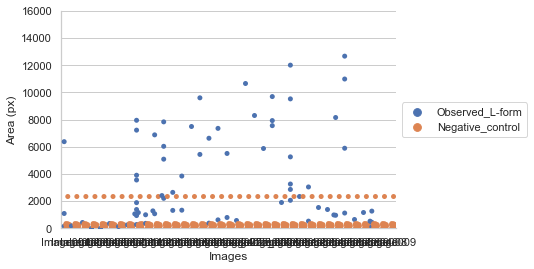

In [115]:
%matplotlib inline
sns.set(style="whitegrid")

g = sns.swarmplot(x="serie", y="roi_px_area", hue="type_image", data=df_results[df_results['channel']=='GFP'], dodge=True)

g.set(xlabel="Images", ylabel = "Area (px)")
g.set(ylim=(0,16000))
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
g = sns.despine(top=True, right=True, left=False, bottom=False, offset=0, trim=False)

plt.show()

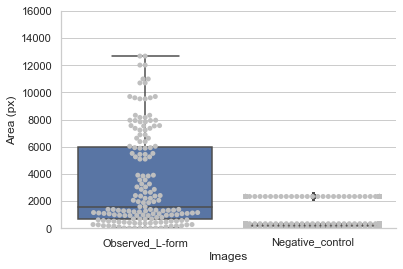

In [116]:
%matplotlib inline
sns.set(style="whitegrid")

g2 = sns.boxplot(x="type_image", y="roi_px_area", data=df_results)
g2 = sns.swarmplot(x="type_image", y="roi_px_area", data=df_results, color=".75")

g2.set(xlabel="Images", ylabel = "Area (px)")
g2.set(ylim=(0,16000))
g2 = sns.despine(top=True, right=True, left=False, bottom=False, offset=0, trim=False)

plt.show()

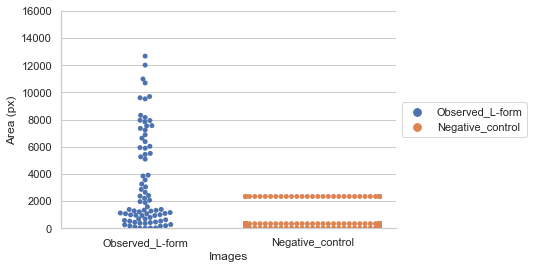

In [117]:
%matplotlib inline
sns.set(style="whitegrid")

g3 = sns.swarmplot(x="type_image", y="roi_px_area", hue="type_image", data=df_results[df_results['channel']=='GFP'], dodge=False)

g3.set(xlabel="Images", ylabel = "Area (px)")
g3.set(ylim=(0,16000))
g3.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
g3 = sns.despine(top=True, right=True, left=False, bottom=False, offset=0, trim=False)

plt.show()

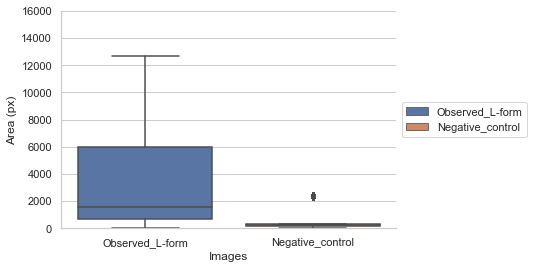

In [118]:
%matplotlib inline
sns.set(style="whitegrid")

g4 = sns.boxplot(x="type_image", y="roi_px_area", hue="type_image", data=df_results[df_results['channel']=='GFP'], dodge=False)

g4.set(xlabel="Images", ylabel = "Area (px)")
g4.set(ylim=(0,16000))
g4.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
g4 = sns.despine(top=True, right=True, left=False, bottom=False, offset=0, trim=False)

plt.show()

##### Average pixel intensity

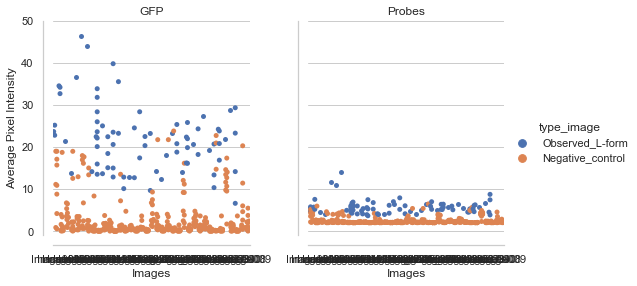

In [119]:
%matplotlib inline
sns.set(style="whitegrid")

h = sns.catplot(x="serie", y="average_px_intensity", hue="type_image", col='channel', data=df_results, kind='swarm', dodge=True, height=4, aspect=.9, sharey=True)

(h.set_axis_labels("Images", "Average Pixel Intensity")
    #.set_xticklabels()
    .set_titles("{col_name}")
    .set(ylim=(-1,50))
    .despine(top=True, right=True, left=False, bottom=False, offset=10, trim=False))  

plt.show()

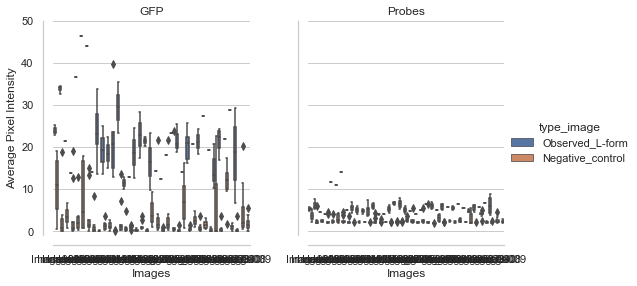

In [120]:
%matplotlib inline
sns.set(style="whitegrid")

h2 = sns.catplot(x="serie", y="average_px_intensity", hue="type_image", col='channel', data=df_results, kind='box', dodge=True, height=4, aspect=.9, sharey=True)
#h2 = sns.catplot(x="serie", y="average_px_intensity", hue="type_image", col='channel', data=df_results, kind='swarm', dodge=True, height=4, aspect=.9, sharey=True, color=".25")

(h2.set_axis_labels("Images", "Average Pixel Intensity")
    #.set_xticklabels()
    .set_titles("{col_name}")
    .set(ylim=(-1,50))
    .despine(top=True, right=True, left=False, bottom=False, offset=10, trim=False)) 

plt.show()

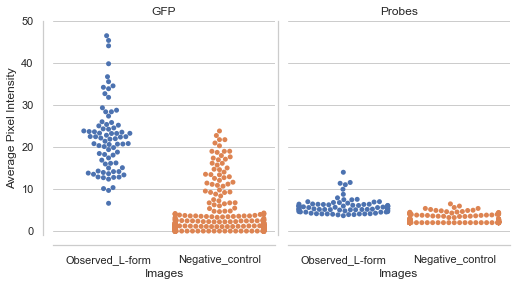

In [121]:
%matplotlib inline
sns.set(style="whitegrid")

h3 = sns.catplot(x="type_image", y="average_px_intensity", hue="type_image", col='channel', data=df_results, kind='swarm', dodge=False, height=4, aspect=.9, sharey=True)

(h3.set_axis_labels("Images", "Average Pixel Intensity")
    #.set_xticklabels()
    .set_titles("{col_name}")
    .set(ylim=(-1,50))
    .despine(top=True, right=True, left=False, bottom=False, offset=10, trim=False))  

plt.show()

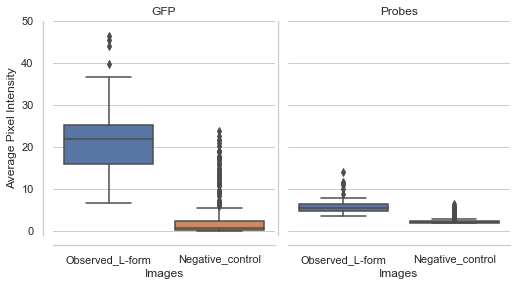

In [122]:
%matplotlib inline
sns.set(style="whitegrid")

h4 = sns.catplot(x="type_image", y="average_px_intensity", hue="type_image", col='channel', data=df_results, kind='box', dodge=False, height=4, aspect=.9, sharey=True)

(h4.set_axis_labels("Images", "Average Pixel Intensity")
    #.set_xticklabels()
    .set_titles("{col_name}")
    .set(ylim=(-1,50))
    .despine(top=True, right=True, left=False, bottom=False, offset=10, trim=False))  

plt.show()

##### Minimal px intensity

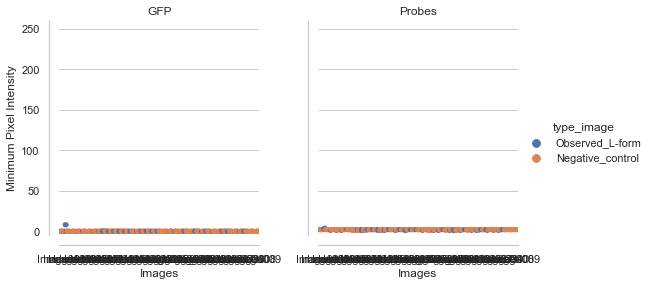

In [123]:
%matplotlib inline
sns.set(style="whitegrid")

j = sns.catplot(x="serie", y="min_px_intensity", hue="type_image", col='channel', data=df_results, kind='swarm', dodge=True, height=4, aspect=.9, sharey=True)

(j.set_axis_labels("Images", "Minimum Pixel Intensity")
    #.set_xticklabels()
    .set_titles("{col_name}")
    .set(ylim=(-5,260))
    .despine(top=True, right=True, left=False, bottom=False, offset=10, trim=False))  

plt.show()

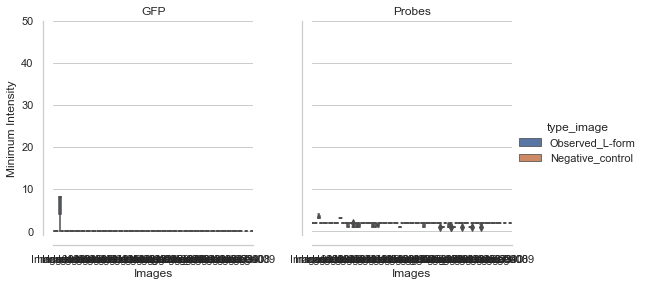

In [124]:
%matplotlib inline
sns.set(style="whitegrid")

j2 = sns.catplot(x="serie", y="min_px_intensity", hue="type_image", col='channel', data=df_results, kind='box', dodge=True, height=4, aspect=.9, sharey=True)
#h2 = sns.catplot(x="serie", y="average_px_intensity", hue="type_image", col='channel', data=df_results, kind='swarm', dodge=True, height=4, aspect=.9, sharey=True, color=".25")

(j2.set_axis_labels("Images", "Minimum Intensity")
    #.set_xticklabels()
    .set_titles("{col_name}")
    .set(ylim=(-1,50))
    .despine(top=True, right=True, left=False, bottom=False, offset=10, trim=False)) 

plt.show()

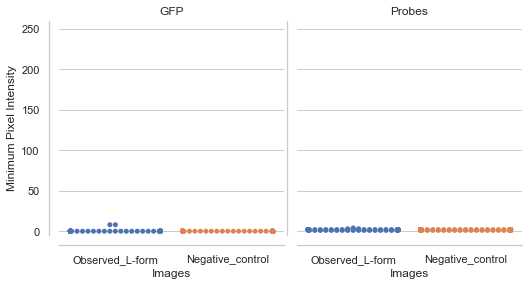

In [125]:
%matplotlib inline
sns.set(style="whitegrid")

j3 = sns.catplot(x="type_image", y="min_px_intensity", hue="type_image", col='channel', data=df_results, kind='swarm', dodge=False, height=4, aspect=.9, sharey=True)

(j3.set_axis_labels("Images", "Minimum Pixel Intensity")
    #.set_xticklabels()
    .set_titles("{col_name}")
    .set(ylim=(-5,260))
    .despine(top=True, right=True, left=False, bottom=False, offset=10, trim=False))  

plt.show()

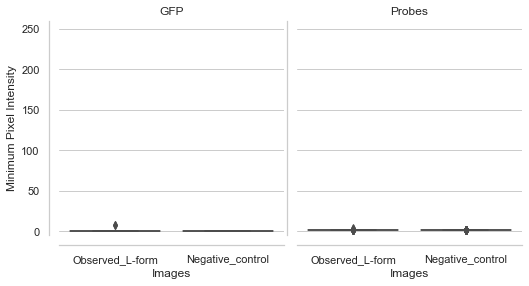

In [126]:
%matplotlib inline
sns.set(style="whitegrid")

j4 = sns.catplot(x="type_image", y="min_px_intensity", hue="type_image", col='channel', data=df_results, kind='box', dodge=False, height=4, aspect=.9, sharey=True)

(j4.set_axis_labels("Images", "Minimum Pixel Intensity")
    #.set_xticklabels()
    .set_titles("{col_name}")
    .set(ylim=(-5,260))
    .despine(top=True, right=True, left=False, bottom=False, offset=10, trim=False))  

plt.show()

##### Maximal px intensity

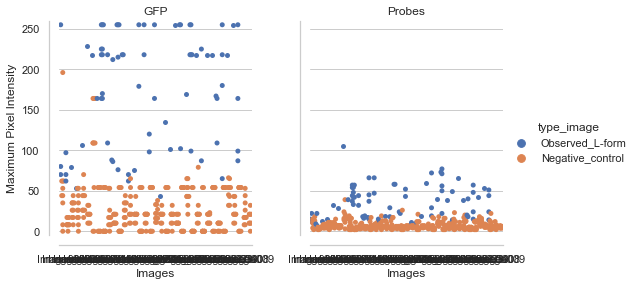

In [127]:
%matplotlib inline
sns.set(style="whitegrid")

k = sns.catplot(x="serie", y="max_px_intensity", hue="type_image", col='channel', data=df_results, kind='swarm', dodge=True, height=4, aspect=.9, sharey=True)

(k.set_axis_labels("Images", "Maximum Pixel Intensity")
    #.setx_xticklabels()
    .set_titles("{col_name}")
    .set(ylim=(-5,260))
    .despine(top=True, right=True, left=False, bottom=False, offset=10, trim=False))  

plt.show()

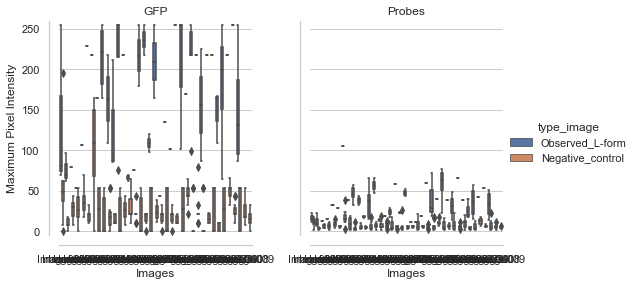

In [128]:
%matplotlib inline
sns.set(style="whitegrid")

k2 = sns.catplot(x="serie", y="max_px_intensity", hue="type_image", col='channel', data=df_results, kind='box', dodge=True, height=4, aspect=.9, sharey=True)

(k2.set_axis_labels("Images", "Maximum Pixel Intensity")
    #.set_xticklabels()
    .set_titles("{col_name}")
    .set(ylim=(-5,260))
    .despine(top=True, right=True, left=False, bottom=False, offset=10, trim=False))  

plt.show()

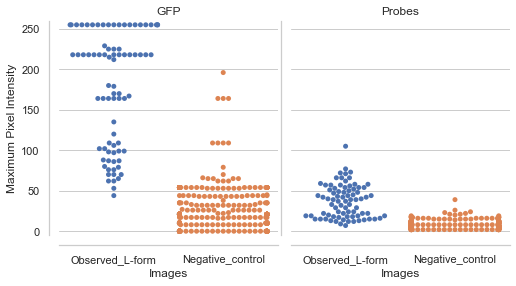

In [129]:
%matplotlib inline
sns.set(style="whitegrid")

k3 = sns.catplot(x="type_image", y="max_px_intensity", hue="type_image", col='channel', data=df_results, kind='swarm', dodge=False, height=4, aspect=.9, sharey=True)

(k3.set_axis_labels("Images", "Maximum Pixel Intensity")
    #.set_xticklabels()
    .set_titles("{col_name}")
    .set(ylim=(-5,260))
    .despine(top=True, right=True, left=False, bottom=False, offset=10, trim=False))  

plt.show()

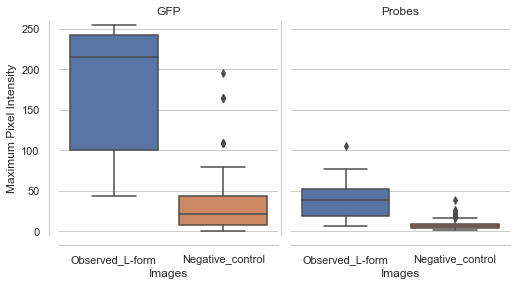

In [130]:
%matplotlib inline
sns.set(style="whitegrid")

k4 = sns.catplot(x="type_image", y="max_px_intensity", hue="type_image", col='channel', data=df_results, kind='box', dodge=False, height=4, aspect=.9, sharey=True)

(k4.set_axis_labels("Images", "Maximum Pixel Intensity")
    #.set_xticklabels()
    .set_titles("{col_name}")
    .set(ylim=(-5,260))
    .despine(top=True, right=True, left=False, bottom=False, offset=10, trim=False))  

plt.show()

#### Apply the resulting thresholding for enhancing the images brightness

In [135]:
def enhanced_img(image_list, threshold_low, threshold_high, brightness_factor):
    '''Return the list of enhanced images'''
    
    enhanced_image_list = []
    
    for img in image_list:
        #new_img = np.where(img < threshold_low, 0, img)
        #enhanced_image_list.append(np.where(new_img > threshold_high, brightness_factor*new_img, new_img))
        enhanced_image_list.append(np.where(img < threshold_low, 0, brightness_factor*img))
        
    return enhanced_image_list

In [136]:
brightness_factor_gfp_channel = 250
brightness_factor_probe_channel = 270

threshold_low_gfp_channel = df_results.loc[(df_results['type_image'] == 'Negative_control') & (df_results['channel'] == 'GFP')][['max_px_intensity']].max().tolist()
threshold_low_probe_channel = df_results.loc[(df_results['type_image'] == 'Negative_control') & (df_results['channel'] == 'Probes')][['max_px_intensity']].max().tolist()

threshold_high_gfp_channel = df_results.loc[(df_results['type_image'] == 'Negative_control') & (df_results['channel'] == 'GFP')][['average_px_intensity']].max().tolist()
threshold_high_probe_channel = df_results.loc[(df_results['type_image'] == 'Negative_control') & (df_results['channel'] == 'Probes')][['average_px_intensity']].max().tolist()

enhanced_gfp_img = enhanced_img(gfp_img, threshold_low_gfp_channel, threshold_high_gfp_channel, brightness_factor_gfp_channel)
enhanced_probe_img = enhanced_img(probe_img, threshold_low_probe_channel, threshold_high_probe_channel, brightness_factor_probe_channel)

In [133]:
#nucleus_idx = [img1[0], img2[0], img3[0]]
#DIC_idx = [img1[2], img2[2], img3[2]]

nucleus_img = get_images_from_idx(nucleus_idx)
DIC_img = get_images_from_idx(DIC_idx)

In [134]:
enhanced_DIC_img = []

for img in DIC_img:
    enhanced_DIC_img.append(img*3)

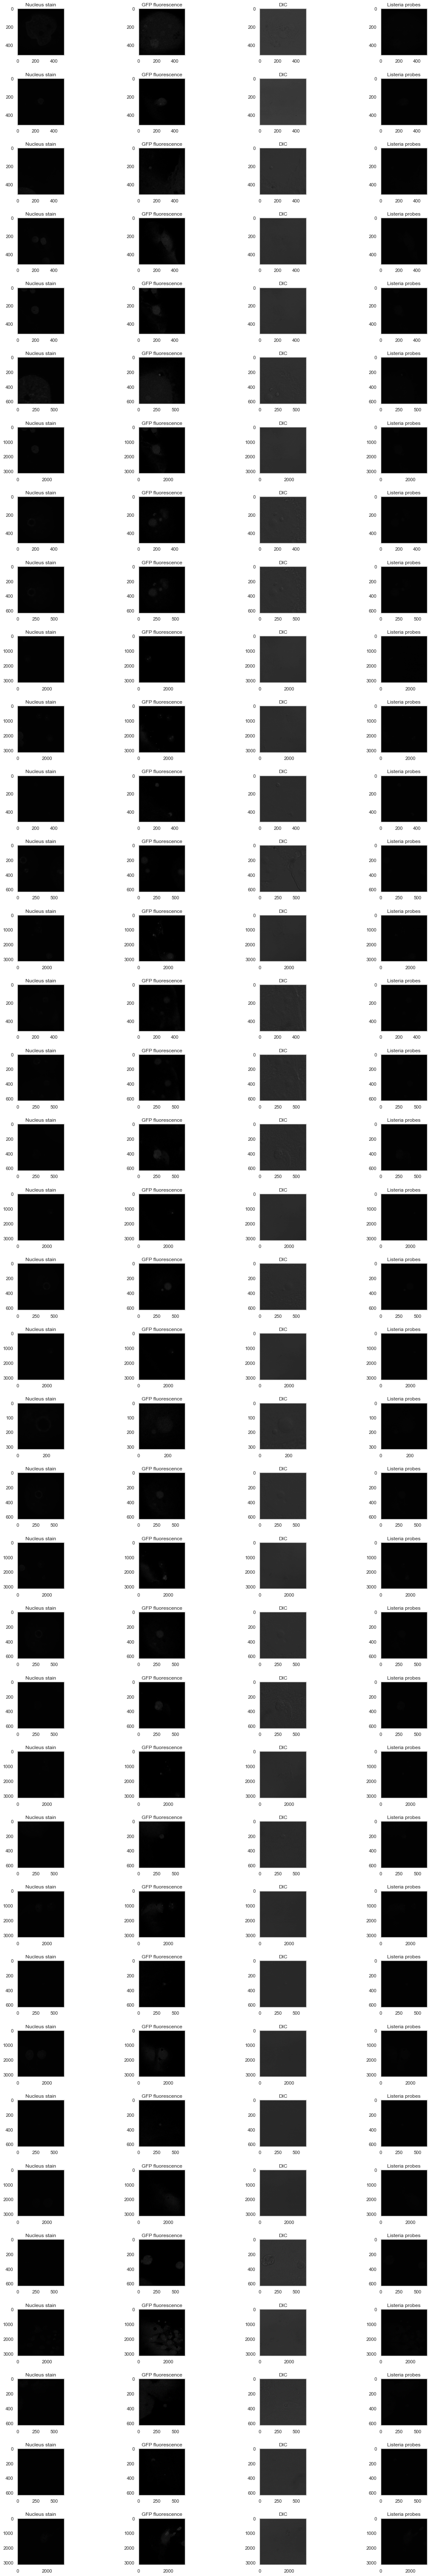

CPU times: user 44.6 s, sys: 1.71 s, total: 46.3 s
Wall time: 46.9 s


In [89]:
%%time
%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

row = len(gfp_idx)
col = 4

a = col*5
b = row*3

k = 0

sequence = [nucleus_img, gfp_img, DIC_img, probe_img]
title = ['Nucleus stain', 'GFP fluorescence', 'DIC', 'Listeria probes']
color_maps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray]
v_min = [0, 0, 0, 0]
v_max = [255, 255, 255, 255]

fig = plt.figure(figsize=(a, b))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
for i in range(row):
    for j in range(len(sequence)):
        plt.subplot(row, col, k+1)
        plt.imshow(sequence[j][i], cmap = color_maps[j], vmin=v_min[j], vmax=v_max[j])
        plt.title(title[j])
        k=k+1
        
    
plt.show()

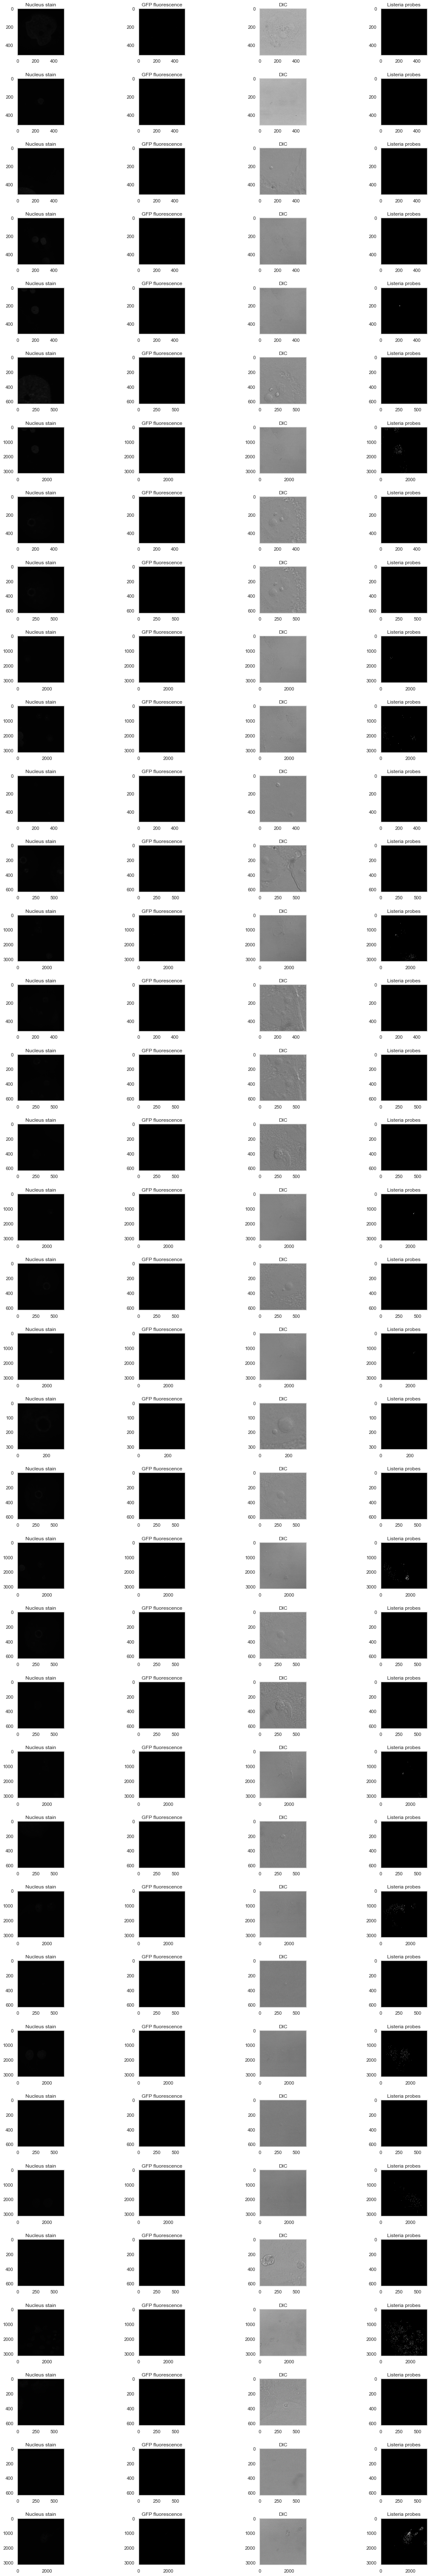

CPU times: user 42.2 s, sys: 1.59 s, total: 43.8 s
Wall time: 43.8 s


In [137]:
%%time
%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

row = len(gfp_idx)
col = 4

a = col*5
b = row*3

k = 0

sequence = [nucleus_img, enhanced_gfp_img, enhanced_DIC_img, enhanced_probe_img]
title = ['Nucleus stain', 'GFP fluorescence', 'DIC', 'Listeria probes']
color_maps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray]
v_min = [0, 0, 0, 0]
v_max = [255, 255, 255, 255]

fig = plt.figure(figsize=(a, b))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
for i in range(row):
    for j in range(len(sequence)):
        plt.subplot(row, col, k+1)
        plt.imshow(sequence[j][i], cmap = color_maps[j], vmin=v_min[j], vmax=v_max[j])
        plt.title(title[j])
        k=k+1
        
    
plt.show()

In [ ]:
# Save the images:

# Original
for idx, img in zip(gfp_idx, gfp_img):
    imageio.imwrite(f'extracted_images/original_img_{idx}.tiff', img)
    
for idx, img in zip(DIC_idx, DIC_img):
    imageio.imwrite(f'extracted_images/original_img_{idx}.tiff', img)
    
for idx, img in zip(probe_idx, probe_img):
    imageio.imwrite(f'extracted_images/original_img_{idx}.tiff', img)

# Enhanced
for idx, img in zip(gfp_idx, enhanced_gfp_img):
    imageio.imwrite(f'extracted_images/enh_img_{idx}.tiff', img)
    
for idx, img in zip(DIC_idx, enhanced_DIC_img):
    imageio.imwrite(f'extracted_images/enh_img_{idx}.tiff', img)
    
for idx, img in zip(probe_idx, enhanced_probe_img):
    imageio.imwrite(f'extracted_images/enh_img_{idx}.tiff', img)